# Intro figure

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ['JAX_ENABLE_X64'] = '1'

cache_path = "../../cache/"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import corc
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram
from collections import Counter
import sklearn
import studenttmixture
import corc.mixture
import itertools
import corc.vizualization
import corc.tmm_plots
import corc.utils

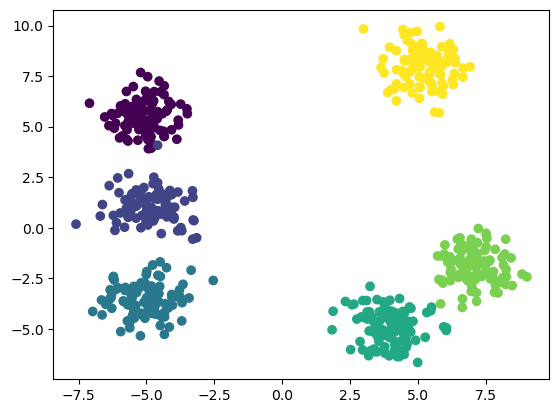

In [3]:
dataset_filename = 'intro_figure.pickle'
with open(cache_path + dataset_filename, 'rb') as f:
    X, y = pickle.load(f)

y = np.array(y,dtype=int)

plt.scatter(X[:, 0], X[:, 1], c=y)

In [4]:
model_filename = "intro_figure_TMM-NEB.pickle"
with open(cache_path + model_filename, 'rb') as f:
    tmm_model = pickle.load(f)

y_pred = np.array(tmm_model.predict(X),dtype=int)

In [74]:
edges=False

In [5]:
pairs = tmm_model.get_merged_pairs(
    target_num_classes=len(set(y)), only_mst_edges=True
)

In [6]:
pairs2 = tmm_model.get_merged_pairs(
    target_num_classes=3, only_mst_edges=True
)

In [ ]:
original_linkage = []
new_clusters = {}
amount_of_points = dict(Counter(tmm_model.predict(X).tolist()))
counting = len(amount_of_points) 
prev = []
start_num = 0

initial_num_clusters = len(tmm_model.mixture_model.weights)
for i in range(initial_num_clusters-1, 0, -1):
    cur = tmm_model.get_merged_pairs(
            target_num_classes=i, only_mst_edges=True
        )
    new_edge = list(set(cur).difference(set(prev)))
    print(new_edge)
    assert len(new_edge) == 1
    new_edge = new_edge[0]
    prev = cur
    new_amount = 0
    
    loc = new_edge[0]
    while loc in new_clusters:
        loc = new_clusters[loc]
    new_amount += amount_of_points[loc]
    new_clusters[loc] = counting
    from_ = loc
    
    loc = new_edge[1]
    while loc in new_clusters:
        loc = new_clusters[loc]
    new_amount += amount_of_points[loc]
    new_clusters[loc] = counting
    to = loc
    

    original_linkage.append([from_, to, 
                    max(-tmm_model.adjacency_[new_edge[0], new_edge[1]], 0.01), 
                    new_amount])

    amount_of_points[counting] = new_amount
    counting += 1

In [8]:
# adjusted from corc.utils
def plot_field(
    data_X,
    mixture_model,
    levels=20,
    paths=None,  # storage of all paths
    selection=None,  # selection which paths to plot
    save_path=None,
    axis=None,
    plot_points=True,  # whether data_X is plotted
    transformed_points=None,
    grid_resolution=128,
    plot_ids=True,
    markersize=3
):
    """Plots the TMM/GMM field and the optimized paths (if available).
    selection: selects which paths are included in the plot, by default, all paths are included.
      other typical options: MST through selection=zip(mst.row,mst.col) and individuals via e.g. [(0,1), (3,4)]

    """
    locations = corc.utils.mixture_center_locations(mixture_model)
    n_components = len(locations)

    
    transformed_points = data_X

    # plot the energy landscape if possible
    if data_X.shape[-1] == 2:
        mixture_model.plot_energy_landscape(
            data_X,
            axis=axis,
            levels=levels,
        )

    # plot the raw data
    if plot_points:
        axis.scatter(
            transformed_points[:, 0], transformed_points[:, 1], s=markersize
        )

    # plot cluster centers and IDs
    axis.scatter(
        locations[:, 0],
        locations[:, 1],
        color="black",
        marker="X",
        s=markersize*2,
    )
    if plot_ids:
        for i, location in enumerate(locations):
            y_min, y_max = axis.get_ylim()
            scale = y_max - y_min
            if i == 10:
                axis.text(location[0]-0.2, location[1]+0.1, f"{i}", color="black", fontsize=6)
            elif i == 8 or i == 3 or i==9:
                axis.text(location[0]-0.1, location[1]-0.4, f"{i}", color="black", fontsize=6)
            else:
                axis.text(location[0]+0.1, location[1]+0.1, f"{i}", color="black", fontsize=6)
                
    # plot paths between centers (by default: all)
    if paths is not None:
        if selection is None:
            selection = list(itertools.combinations(range(n_components), r=2))
        for i, j in selection:
            # path = paths[(i, j)]
            # axis.plot(path[:, 0], path[:, 1], lw=2, alpha=0.5, color="black")
            start = locations[i]
            end = locations[j]
            axis.plot(
                *zip(start, end),
                color="black",
                alpha=1,
            )


In [9]:
custom_colors = [
    corc.vizualization.COLOR_DICT['petrol'],
    corc.vizualization.COLOR_DICT['green'],
    corc.vizualization.COLOR_DICT['red'],
    corc.vizualization.COLOR_DICT['orange'],
    corc.vizualization.COLOR_DICT['purple'],
    corc.vizualization.COLOR_DICT['turquoise'],
    # 'steelblue', 'sandybrown', 
    #              # 'red', 
    #              'darkturquoise', 'tomato', 
    #              'mediumslateblue', 
    #              'firebrick', 'magenta', 'olive', 'limegreen', 
]
from scipy.cluster.hierarchy import set_link_color_palette
set_link_color_palette(custom_colors) # this will be left-to-right

cluster_colors = [
    corc.vizualization.COLOR_DICT['purple'], # 0
    corc.vizualization.COLOR_DICT['orange'], # 1 
    corc.vizualization.COLOR_DICT['petrol'], # 2
    corc.vizualization.COLOR_DICT['green'], # 3
    corc.vizualization.COLOR_DICT['turquoise'], # 4
    corc.vizualization.COLOR_DICT['red'],  # 5
    corc.vizualization.COLOR_DICT['green_50'], # 6
    corc.vizualization.COLOR_DICT['green_75'], # 7
    corc.vizualization.COLOR_DICT['purple_25'], # 8
    corc.vizualization.COLOR_DICT['yellow_75'], # 9
    corc.vizualization.COLOR_DICT['petrol_50'], # 10
    corc.vizualization.COLOR_DICT['turquoise_50'], # 11
    corc.vizualization.COLOR_DICT['orange_50'], # 12
    corc.vizualization.COLOR_DICT['purple_50'], # 13
    corc.vizualization.COLOR_DICT['red_50'], # 14
]

cluster_colors2 = [
    corc.vizualization.COLOR_DICT['purple'], # 0
    corc.vizualization.COLOR_DICT['yellow'], # 1 
    corc.vizualization.COLOR_DICT['petrol'], # 2
    corc.vizualization.COLOR_DICT['green'], # 3
    corc.vizualization.COLOR_DICT['turquoise'], # 4
    corc.vizualization.COLOR_DICT['red'],  # 5
    corc.vizualization.COLOR_DICT['green'], # 6
    corc.vizualization.COLOR_DICT['green'], # 7
    corc.vizualization.COLOR_DICT['purple'], # 8
    corc.vizualization.COLOR_DICT['yellow'], # 9
    corc.vizualization.COLOR_DICT['petrol'], # 10
    corc.vizualization.COLOR_DICT['turquoise'], # 11
    corc.vizualization.COLOR_DICT['yellow'], # 12
    corc.vizualization.COLOR_DICT['purple'], # 13
    corc.vizualization.COLOR_DICT['red'], # 14
]

y_colors = [cluster_colors[i] for i in y_pred]


/scratch/tmp/nimmr000/ipykernel_3096117/3119204390.py:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


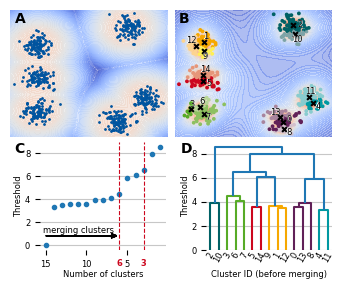

In [73]:
edges=True
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(3.5, 3.5), gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 1]}) 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(3.5, 2.9), gridspec_kw={'height_ratios': [2, 2]})

# fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

# fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(6, 6), gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 1,1,1]}) 
axes = axes.flatten()

MARKERSIZE = 6
# -------------
# Generating distribution
ax = axes[0]
ax.set_axis_off()
# create new axis to actually fill the available space
ax = plt.axes([0.03, 0.54, 0.45, .44])  # [left, bottom, width, height]
ax.set_axis_off()

covs = np.array([np.diag((1,1))]).repeat(6, axis=0)*0.8
mixture_model = corc.mixture.GaussianMixtureModel(
    centers=np.array([(-5,5.5),(-5,1),(-5,-3.5),(4,-5),(7,-2),(5,8)]),
    covs=covs,
    weights=[1,1,1,1,1,1]
)
mixture_model.plot_energy_landscape(
    data_X=X,
    axis=ax,levels=60, 
    kwargs=dict(vmax=15)
)
ax.scatter(X[:,0],X[:,1],s=1,c=corc.vizualization.COLOR_DICT['blue'])
ax.text(0.03, 0.9, 'A', transform=ax.transAxes, 
            size=10, weight='bold')
# -------------
ax = axes[1]
ax.set_axis_off()
ax = plt.axes([0.5, 0.54, 0.45, .44])  # [left, bottom, width, height]
ax.set_axis_off()

# background
tmm_model.mixture_model.plot_energy_landscape(
    data_X=X,
    levels=60,
    axis=ax,
)
# points
ax.scatter(X[:, 0], X[:, 1], c=y_colors, s=MARKERSIZE/2, alpha=1)

# centers
centers = tmm_model.mixture_model.centers
ax.scatter(centers[:, 0], centers[:, 1], c="black", marker="x", s=2*MARKERSIZE,zorder=20)

# numbers for clusters
offsets = { 
    7: (0.5,-.8),
    13: (-0.5,.3),
    8: (0.5,-.8),
    0: (0.7,0),
    10: (0.2,-1.1),
    9: (0.2,-1.1),
    12: (-0.6,0.4),
    5: (0.6,-0.6),
    4: (0.6,-0.8),
    2: (0.7,-.2),
}
for i, center in enumerate(centers):
    if i in offsets.keys():
        offset = offsets[i]
    else:
        offset = (0.2,0.4)
    ax.text(center[0]+offset[0], center[1]+offset[1], f"{i}", color="white", fontsize=6,weight="bold",ha='center',zorder=100)
    ax.text(center[0]+offset[0], center[1]+offset[1], f"{i}", color="black", fontsize=6,ha='center', zorder=101)

# edges
pairs2 = tmm_model.get_merged_pairs(
    target_num_classes=6, only_mst_edges=True
)
pairs2 += [(7,13),(11,10),(9,14),(5,6),(0,4)]
if edges: 
    for pair in pairs2:
        if pair in tmm_model.paths_.keys():
            path = tmm_model.paths_[(pair[0], pair[1])]
            ax.plot(path[:, 0], 
                    path[:, 1], 
                    alpha=.9, 
                    color=corc.vizualization.COLOR_DICT["black_50"],
                    lw=30/(tmm_model.adjacency_[pair[0], pair[1]])**2
            )

# marker B
ax.text(0.03, 0.9, 'B', transform=ax.transAxes, 
            size=10, weight='bold')
ax.axis('off') 
ax = axes[2]

threshold_dict, _ = tmm_model.get_thresholds_and_cluster_numbers()
xs = sorted(list(threshold_dict.keys()))[::-1]
ys  = [-threshold_dict[x] for x in xs]
ax.plot(xs, ys, marker="o", markersize=MARKERSIZE/2, lw=0)
ax.set_xlabel("Number of clusters", fontsize=6, labelpad=1)
ax.set_ylabel("Threshold", fontsize=6, labelpad=1)
# plt.title("Clusters")

# arrow with text
ax.arrow(15, 0.8, -8, 0, head_width=.4, head_length=0.7, overhang=1)
ax.text(11, 1.1, 'merging clusters', ha='center', fontsize=6)

# vertical lines
ax.axvline(x=3, color=corc.vizualization.COLOR_DICT['red'], linestyle='--', lw=.8)
ax.axvline(x=6, color=corc.vizualization.COLOR_DICT['red'], linestyle='--', lw=.8)
ax.text(6,-1.85,"6", fontsize=6,ha='center',c=corc.vizualization.COLOR_DICT['red'], weight='bold')
ax.text(3,-1.85,"3", fontsize=6,ha='center',c=corc.vizualization.COLOR_DICT['red'], weight='bold')

ax.grid(axis='y', alpha=0.7)
ax.invert_xaxis()
corc.tmm_plots.remove_border(ax)
ax.tick_params(axis='both', labelsize=6)
# ax.tick_params(axis='x', which='major', pad=0,)

ax.text(-0.2, 0.9, 'C', transform=ax.transAxes, 
            size=10, weight='bold')
# -------------
ax = axes[3]
corc.tmm_plots.remove_border(ax)
ax.grid(axis='y', alpha=0.7)
# ax.set_yticklabels([])
# ax.set_yticks([])

dendrogram(original_linkage, color_threshold=5, ax=ax)
ax.tick_params(axis='x', which='major', pad=-3,rotation=60)
ax.set_xlabel("Cluster ID (before merging)", labelpad=4, fontsize=6)
ax.tick_params(axis='both', labelsize=6)
ax.set_ylabel('Threshold', fontsize=6, labelpad=1)
ax.text(-0.2, 0.9, 'D', transform=ax.transAxes, 
            size=10, weight='bold')

plt.tight_layout()
# plt.subplots_adjust(
#     wspace=0.25, 
#     hspace=0.25
# )
if edges:
    figure_path = "../../figures/intro_figure_edges.png"
else:
    figure_path = "../../figures/intro_figure.png"
plt.savefig(
    # f"{pre}figures/claude_neb_join_strategies_{dataset_name}_seed_{seed}_n_components_{n_components}.pdf",
    figure_path, bbox_inches='tight', pad_inches=0, dpi=600)

/scratch/tmp/nimmr000/ipykernel_706122/560851905.py:209: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


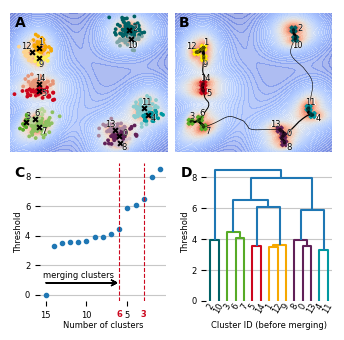

In [95]:
edges=True
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(3.5, 3.5), gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 1]}) 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(3.5, 3.5) )

# fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

# fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(6, 6), gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 1,1,1]}) 
axes = axes.flatten()

# -------------
# Generating distribution
ax = axes[0]
ax.set_axis_off()
# create new axis to actually fill the available space
ax = plt.axes([0.03, 0.55, 0.45, .4])  # [left, bottom, width, height]
ax.set_axis_off()


MARKERSIZE = 6
ax.scatter(X[:, 0], X[:, 1], c=y_colors, s=MARKERSIZE/2)

tmm_model.mixture_model.plot_energy_landscape(
    data_X=X,
    mixture_model=tmm_model.mixture_model,
    levels=60,
    axis=ax,
)
centers = tmm_model.mixture_model.centers
ax.scatter(centers[:, 0], centers[:, 1], c="black", marker="x", s=2*MARKERSIZE)
offsets = { 
    7: (0.5,-.8),
    13: (-0.5,.3),
    8: (0.5,-.8),
    0: (0.7,0),
    10: (0.2,-1.1),
    9: (0.2,-1.1),
    12: (-0.6,0.4),
    5: (0.6,-0.6),
    4: (0.6,-0.8),
    2: (0.7,-.2),
}
for i, center in enumerate(centers):
    if i in offsets.keys():
        offset = offsets[i]
    else:
        offset = (0.2,0.4)
    ax.text(center[0]+offset[0], center[1]+offset[1], f"{i}", color="white", fontsize=6,weight="bold",ha='center')
    ax.text(center[0]+offset[0], center[1]+offset[1], f"{i}", color="black", fontsize=6,ha='center')


ax.text(0.03, 0.9, 'A', transform=ax.transAxes, 
            size=10, weight='bold')
# -------------
ax = axes[1]
ax.set_axis_off()
ax = plt.axes([0.5, 0.55, 0.45, .4])  # [left, bottom, width, height]
ax.set_axis_off()

tmm_model.mixture_model.plot_energy_landscape(
    data_X=X,
    mixture_model=tmm_model.mixture_model,
    levels=60,
    axis=ax,
)

offsets = { 
    7: (0.5,-.8),
    13: (-0.5,.3),
    8: (0.5,-.8),
    0: (0.7,0),
    10: (0.2,-1.1),
    9: (0.2,-1.1),
    12: (-0.6,0.4),
    5: (0.6,-0.6),
    4: (0.6,-0.8),
    2: (0.7,-.2),
}
for i, center in enumerate(centers):
    if i in offsets.keys():
        offset = offsets[i]
    else:
        offset = (0.2,0.4)
    ax.text(center[0]+offset[0], center[1]+offset[1], f"{i}", color="white", fontsize=6,weight="bold",ha='center')
    ax.text(center[0]+offset[0], center[1]+offset[1], f"{i}", color="black", fontsize=6,ha='center')



pairs2 = tmm_model.get_merged_pairs(
    target_num_classes=6, only_mst_edges=True
)
pairs2 += [(7,13),(11,10),(9,14),(5,6),(0,4)]

for pair in pairs2:
    if pair in tmm_model.paths_.keys():
        path = tmm_model.paths_[(pair[0], pair[1])]
        ax.plot(path[:, 0], 
                path[:, 1], 
                alpha=1, 
                color=corc.vizualization.COLOR_DICT["black"],
                lw=30/(tmm_model.adjacency_[pair[0], pair[1]])**2
        )

    # if pair in pairs:
    #     continue
    # start = tmm_model.mixture_model.centers[pair[0]]
    # end = tmm_model.mixture_model.centers[pair[1]]
    # ax.plot(*zip(start, end), color=corc.vizualization.COLOR_DICT["black"], alpha=1, lw=8/tmm_model.adjacency_[pair[0], pair[1]])

ax.scatter(centers[:, 0], centers[:, 1], c=cluster_colors2, marker="X", s=4*MARKERSIZE, zorder=0)
ax.scatter(centers[:, 0], centers[:, 1], c=cluster_colors2, marker="X", s=4*MARKERSIZE, zorder=20, alpha=0.3)




# ax.tick_params(axis='both', labelsize=6)
ax.text(0.03, 0.9, 'B', transform=ax.transAxes, 
            size=10, weight='bold')
ax.axis('off') 

ax = axes[2]

threshold_dict, _ = tmm_model.get_thresholds_and_cluster_numbers()
xs = sorted(list(threshold_dict.keys()))[::-1]
ys  = [-threshold_dict[x] for x in xs]
ax.plot(xs, ys, marker="o", markersize=MARKERSIZE/2, lw=0)
ax.set_xlabel("Number of clusters", fontsize=6, labelpad=1)
ax.set_ylabel("Threshold", fontsize=6, labelpad=1)
# plt.title("Clusters")

# arrow with text
ax.arrow(15, 0.8, -8, 0, head_width=.4, head_length=0.7, overhang=1)
ax.text(11, 1.1, 'merging clusters', ha='center', fontsize=6)

# vertical lines
ax.axvline(x=3, color=corc.vizualization.COLOR_DICT['red'], linestyle='--', lw=.8)
ax.axvline(x=6, color=corc.vizualization.COLOR_DICT['red'], linestyle='--', lw=.8)
ax.text(6,-1.53,"6", fontsize=6,ha='center',c=corc.vizualization.COLOR_DICT['red'], weight='bold')
ax.text(3,-1.53,"3", fontsize=6,ha='center',c=corc.vizualization.COLOR_DICT['red'], weight='bold')

ax.grid(axis='y', alpha=0.7)
ax.invert_xaxis()
corc.tmm_plots.remove_border(ax)
ax.tick_params(axis='both', labelsize=6)
# ax.tick_params(axis='x', which='major', pad=0,)

ax.text(-0.2, 0.9, 'C', transform=ax.transAxes, 
            size=10, weight='bold')
# -------------
ax = axes[3]
corc.tmm_plots.remove_border(ax)
ax.grid(axis='y', alpha=0.7)
# ax.set_yticklabels([])
# ax.set_yticks([])

dendrogram(original_linkage, color_threshold=5, ax=ax)
ax.tick_params(axis='x', which='major', pad=-3,rotation=60)
ax.set_xlabel("Cluster ID (before merging)", labelpad=4, fontsize=6)
ax.tick_params(axis='both', labelsize=6)
ax.set_ylabel('Threshold', fontsize=6, labelpad=1)
ax.text(-0.2, 0.9, 'D', transform=ax.transAxes, 
            size=10, weight='bold')

plt.tight_layout()
# plt.subplots_adjust(
#     wspace=0.25, 
#     hspace=0.25
# )
plt.savefig(
    # f"{pre}figures/claude_neb_join_strategies_{dataset_name}_seed_{seed}_n_components_{n_components}.pdf",
    '../../figures/intro_figure2.png', bbox_inches='tight', pad_inches=0, dpi=600)

# code to create data and model (do not run!)

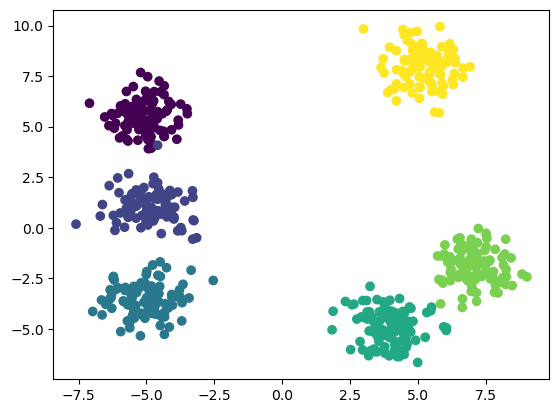

In [41]:
def vec2d_from_angle(angle: float | np.ndarray) -> np.ndarray:
    """
    Convert an angle to a 2D vector
    """
    return np.stack([np.cos(angle), np.sin(angle)], -1)

def create_intro_dataset() -> tuple[np.ndarray, np.ndarray]:
    """
    Simulating six clusters with different push apart degrees and variances,
    example dataset 10 from the R package clusterlab.
    Used in "Sparse clusterability: testing for cluster structure in high
    dimensions" by Laborde et al. (2023).
    """
    # see the 'clusterlab_dataset2' for comments explaining the code
    cs = vec2d_from_angle(np.linspace(0, 2 * np.pi, 6, endpoint=False))
    xs = []
    ys = []

    for i, (center, spread) in enumerate(
        [
            ((-5,5.5),1),
            ((-5,1),1),
            ((-5,-3.5),1),
            ((4,-5),1),
            ((7,-2),1),
            ((5,8),1),
        ]
    ):
        xs.append(np.random.normal(size=(100, 2)) * spread *.8 + center)
        ys.append(np.zeros(100) + i)

    # for i, (c, s, a) in enumerate(

    #     zip(
    #         cs,
    #         [0.5, 1.0, 1.5, 1.75, 2.0, 2.25, 2.25],
    #         [0.5, 1.0, 1.5, 1.75, 1.85, 1.95, 2.05],
    #     )
    # ):
    #     xs.append(np.random.normal(size=(50, 2)) * s + c * 9 * a)
    #     ys.append(np.zeros(50) + i)

    xs = np.vstack(xs)
    ys = np.concatenate(ys)
    return xs, ys

# X,y = create_intro_dataset()



In [40]:
with open(cache_path + dataset_filename, 'wb') as f:
    pickle.dump((X, y), f)

In [65]:
import corc.graph_metrics
import corc.graph_metrics.neb


tmm_model = corc.graph_metrics.neb.NEB(
    data=X,
    labels=y,
    n_components=15,
    optimization_iterations=250,
    min_cluster_size=8,
    max_elongation=100,
    tmm_regularization=1e-2,
)
tmm_model.fit(X)

[[43  3]
 [39  1]
 [72  1]
 [14  6]
 [31  3]
 [52  3]
 [23  4]
 [63  2]
 [22  2]
 [25  2]
 [28  2]
 [68  1]
 [37  1]
 [36  2]
 [47  3]]
After filtering 15 components, we are left with 15 components


tmm: 100%|██████████| 150/150 [02:52<00:00,  1.15s/it]


In [113]:
model_filename = "intro_figure_TMM-NEB.pickle"
with open(cache_path + model_filename, 'wb') as f:
    pickle.dump(tmm_model, f)

In [ ]:
with open(f'{cache_path}clusterlab10_TMM-NEB.pickle', 'rb') as f:
    tmm_model = varied = pickle.load(f)

X, y, transformed_points = corc.utils.load_dataset(
    # dataset_name='varied', 
    # dataset_name='blobs',
    dataset_name='clusterlab10', 
    cache_path=cache_path
)

pairs = varied.get_merged_pairs(
    target_num_classes=len(set(y)), only_mst_edges=True
)